In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, SpatialDropout1D, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

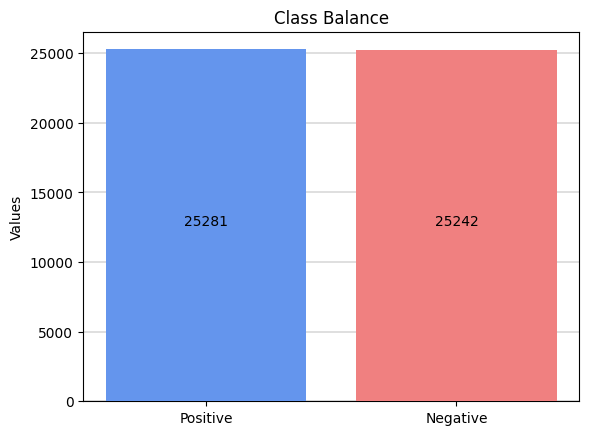

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=5000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 80% data train and 20% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(40418, 3445) (40418,)
(10105, 3445) (10105,)


In [8]:
tf_idf_len

3445

In [9]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [10]:
x_train.shape

(40418, 3445, 1)

In [11]:
y_train.shape

(40418,)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Menentukan model CNN
def cnn(x_train, y_train, x_test, y_test):

    model = Sequential()
    model.add(Input(shape=(tf_idf_len, 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    optimizer = Adam(learning_rate=0.001)
    print(model.summary())
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])


    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 3445, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7236 - loss: 0.4967 - val_accuracy: 0.8209 - val_loss: 0.3801
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7701 - loss: 0.4091 - val_accuracy: 0.8015 - val_loss: 0.4136
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7873 - loss: 0.3802 - val_accuracy: 0.8297 - val_loss: 0.3615
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7998 - loss: 0.3591 - val_accuracy: 0.8232 - val_loss: 0.3691
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8104 - loss: 0.3375 - val_accuracy: 0.8261 - val_loss: 0.3676
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8261 - loss: 0.3145 - val_accuracy: 0.8246 - val_loss: 0.3707


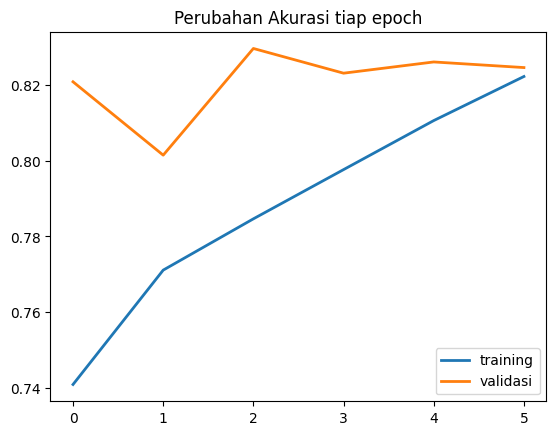

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.810273  0.847206  0.828328      5046
           1   0.840340  0.802135  0.820793      5059

    accuracy                       0.824641     10105
   macro avg   0.825306  0.824670  0.824560     10105
weighted avg   0.825326  0.824641  0.824556     10105



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7209 - loss: 0.4997 - val_accuracy: 0.8016 - val_loss: 0.4224
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7701 - loss: 0.4079 - val_accuracy: 0.8294 - val_loss: 0.3740
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7864 - loss: 0.3784 - val_accuracy: 0.8318 - val_loss: 0.3473
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8043 - loss: 0.3505 - val_accuracy: 0.8326 - val_loss: 0.3525
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8189 - loss: 0.3238 - val_accuracy: 0.8245 - val_loss: 0.3605
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8286 - loss: 0.3037 - val_accuracy: 0.8313 - val_loss: 0.3598


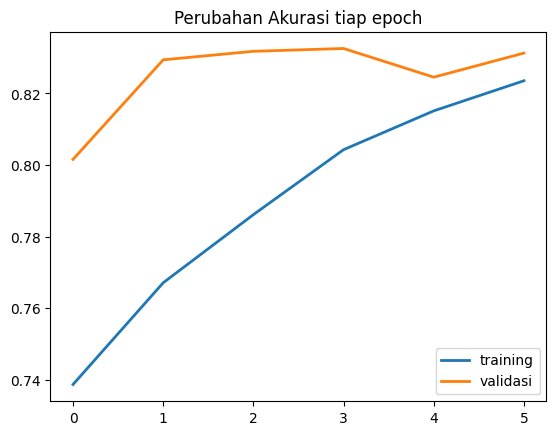

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.841267  0.816092  0.828488      5046
           1   0.821881  0.846412  0.833966      5059

    accuracy                       0.831272     10105
   macro avg   0.831574  0.831252  0.831227     10105
weighted avg   0.831561  0.831272  0.831231     10105



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7184 - loss: 0.5008 - val_accuracy: 0.8216 - val_loss: 0.3727
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7707 - loss: 0.4067 - val_accuracy: 0.8292 - val_loss: 0.3643
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7875 - loss: 0.3722 - val_accuracy: 0.8293 - val_loss: 0.3640
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8015 - loss: 0.3538 - val_accuracy: 0.8239 - val_loss: 0.3661
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8140 - loss: 0.3315 - val_accuracy: 0.8295 - val_loss: 0.3670
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8272 - loss: 0.3087 - val_accuracy: 0.8214 - val_loss: 0.3733


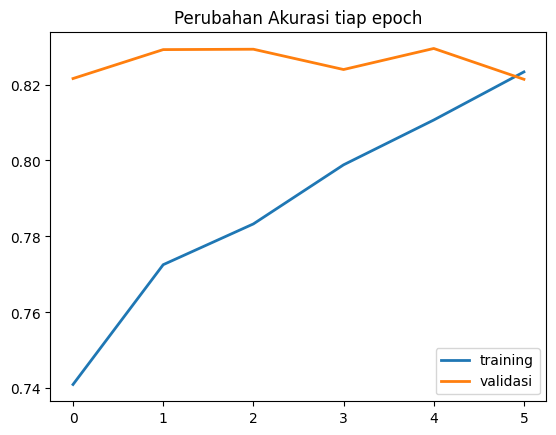

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.833780  0.802220  0.817695      5046
           1   0.809905  0.840482  0.824910      5059

    accuracy                       0.821376     10105
   macro avg   0.821842  0.821351  0.821303     10105
weighted avg   0.821827  0.821376  0.821307     10105



In [14]:
result = []
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8257628236846446
Average Precision : 0.8240417916041541
Average Recall    : 0.8296764841536536
Average F1-Score  : 0.8265564863984013
